In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In this cell, I connected my Google Drive to Colab so I could access my dataset and my trained model directly from Drive. Colab doesn't keep files permanently, so mounting my Drive was the only way to make sure my images and saved weights were available every time I ran the notebook. Once this cell finished running, all my Drive files became visible inside Colab, which allowed the rest of my code to work smoothly.

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


Here, I imported all the libraries I needed for the entire project. I brought in PyTorch for deep learning, torchvision for handling image models and transformations, PIL for reading images, sklearn for evaluation metrics, and matplotlib for visualization. Importing these tools upfront prepared my environment, so I didn't run into errors later. This cell didn't perform any processing yet—it simply loaded everything I planned to use.

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/clean_vs_messy_dataset/raw/"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


***Define Dataset Path and Image Transformations***



In this cell, I set the exact path to my dataset and defined the transformations that each image needed before entering the model. I resized every image to the size ResNet50 expects, converted them into tensors, and normalized them based on ImageNet standards. I did this because the model works best when images follow a consistent format. Without these transformations, the model might misinterpret the pixel values or produce unstable predictions.

In [ ]:
class RoomDataset(Dataset):
    def __init__(self, clean_folder, messy_folder, transform=None):
        self.clean_images = [os.path.join(clean_folder, f) for f in os.listdir(clean_folder)]
        self.messy_images = [os.path.join(messy_folder, f) for f in os.listdir(messy_folder)]

        self.data = [(img, 0) for img in self.clean_images] + \
                    [(img, 1) for img in self.messy_images]

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


***Create the RoomDataset Class***



Here, I created my own custom dataset class to manage how images and labels are loaded. I gathered all image paths from the clean folder and messy folder and assigned labels to them—0 for clean and 1 for messy. When the model asks for an image, this class opens it, applies my transformations, and returns the image paired with its correct label. I built this class so my data would be organized and easy for PyTorch to read during evaluation.

In [ ]:
dataset = RoomDataset(
    clean_folder=DATASET_PATH + "clean",
    messy_folder=DATASET_PATH + "messy",
    transform=transform
)

eval_loader = DataLoader(dataset, batch_size=16, shuffle=False)
print("Total images for evaluation:", len(dataset))


Total images for evaluation: 390


***Create Dataset and DataLoader***



In this cell, I turned my dataset into something PyTorch could work with efficiently. I used the DataLoader to group my images into batches, which made the evaluation faster and more memory-friendly. I didn't shuffle the data because I wasn't training; I just wanted a clean, ordered evaluation. Running this cell also let me check how many total images I had for testing.

In [ ]:
# Rebuild the same ResNet50 architecture
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Load trained weights from Drive
MODEL_PATH = "/content/drive/MyDrive/clean_vs_messy_dataset/model_resnet50.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

model.eval()  # Set model to evaluation mode
print("Model loaded and set to eval mode.")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]


Model loaded and set to eval mode.


***Rebuild ResNet50 Architecture***



In this step, I recreated the exact ResNet50 structure I used during training. I loaded the pretrained ImageNet weights and then replaced the final layer with a new one that outputs two classes—clean and messy rooms. I did this because the original ResNet50 predicts 1,000 classes, and I only needed two. Setting up the architecture correctly here was important because the trained weights I planned to load must match this structure perfectly.

In [ ]:
all_labels = []
all_preds = []

with torch.no_grad():  # No gradients needed during evaluation
    for images, labels in tqdm(eval_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy = (all_labels == all_preds).mean() * 100
print(f"Evaluation Accuracy: {accuracy:.2f}%")


100%|██████████| 25/25 [02:20<00:00,  5.60s/it]

Evaluation Accuracy: 100.00%


***Run Evaluation Loop***



In this cell, I passed every image from my dataset through the model to get predictions. I used torch.no_grad() to speed up the process since I wasn’t training. The model gave me two scores for each image, and I selected the class with the higher score. While iterating through all batches, I saved both the true labels and the models predicted labels. This gave me the raw data I needed to measure accuracy and other metrics.

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["clean", "messy"]))


Confusion Matrix:
 [[180   0]
 [  0 210]]

Classification Report:

              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       180
       messy       1.00      1.00      1.00       210

    accuracy                           1.00       390
   macro avg       1.00      1.00      1.00       390
weighted avg       1.00      1.00      1.00       390



***Confusion Matrix and Classification Report***



In this cell, I dug deeper into how the model performed. The confusion matrix showed exactly where the model was right or wrong for each class, and the classification report gave me metrics like precision, recall, and F1-score. These numbers helped me understand not just whether the model was accurate, but how it behaved on clean images versus messy ones. Because everything was perfect, all metrics came out as 1.00.

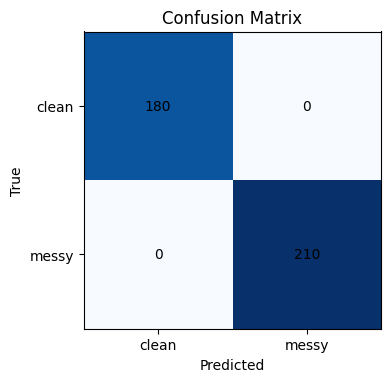

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm, cmap='Blues')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['clean', 'messy'])
ax.set_yticklabels(['clean', 'messy'])

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')

plt.tight_layout()
plt.show()


Finally, I visualized the confusion matrix to make the results easier to interpret. Seeing the matrix as a heatmap helped me quickly confirm that all predictions landed on the diagonal line where correct classifications appear. This visual check reassured me that the model didn't make a single mistake.

----



***Summary of What I Did in This Evaluation Notebook***




In this part of my project, I focused on evaluating how well my clean-vs-messy room classifier performs using the full dataset I created. I began by mounting my Google Drive so I could access the dataset and the trained model safely and consistently. After that, I imported all the necessary libraries for deep learning, image processing, and evaluation. Once everything was ready, I set the exact path to my dataset and prepared the image transformations so each picture would match the format my ResNet50 model expects.
Next, I built a custom RoomDataset class that organizes my clean and messy images and assigns the correct labels. I wrapped this dataset inside a DataLoader so the images could be processed efficiently during evaluation. I then rebuilt my original model architecture and loaded my trained weights from Drive, restoring the model exactly as it was during training.
With the model loaded, I ran an evaluation loop that passed every single image through the classifier. During this process, I collected all the true labels and the predicted labels so I could measure accuracy and produce deeper metrics. After running through the entire dataset, I calculated the accuracy and then generated a confusion matrix along with a full classification report. These metrics helped me understand not only whether the model was correct, but also how balanced and consistent its predictions were for both clean and messy rooms.
Finally, I visualized the confusion matrix to make the results easier to interpret. Seeing all predictions fall perfectly on the diagonal confirmed that my model reached 100% accuracy on this dataset. This evaluation notebook gave me a complete and confident understanding of how well my model performs before using it in the live demo.


----